In [16]:
# corrected_well_conditioned_benchmark.py
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math
torch.manual_seed(0)
np.random.seed(0)

# ---------------------------
# Custom optimizer that uses analytic grad_fn (no autograd inside)
# ---------------------------
class CustomOptimizer4(optim.Optimizer):
    """
    Adam-like optimizer with stability feedback using analytic grad function.
    This optimizer requires a 'grad_fn' callable in its param_group defaults:
        grad_fn: callable(x: torch.Tensor) -> torch.Tensor (same shape as x)
    It performs:
      - biased moment updates using g_old
      - tentative Adam update to x_new
      - compute g_new = grad_fn(x_new)
      - decide scale based on ||g_new - g_old|| vs previous
      - reinforce m with scaled contribution for future updates
    Works with a single 1-D parameter tensor.
    """
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8, scale_drop=0.5):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps, scale_drop=scale_drop)
        super().__init__(params, defaults)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state.setdefault('t', 0)
                state.setdefault('m', torch.zeros_like(p.data))
                state.setdefault('v', torch.zeros_like(p.data))
                state.setdefault('prev_diff', torch.tensor(float('inf'), dtype=p.data.dtype, device=p.data.device))

    @torch.no_grad()
    def step(self, closure=None):
        """
        Note: This step() does NOT call closure() or use autograd.
        Instead it expects the param_group to contain 'grad_fn' callable that can compute gradient at any x.
        """
        loss_value = None
        for group in self.param_groups:
            lr = group['lr']
            b1 = group['beta1']
            b2 = group['beta2']
            eps = group['eps']
            scale_drop = group['scale_drop']
            grad_fn = group.get('grad_fn', None)
            if grad_fn is None:
                raise ValueError("CustomOptimizer4 requires 'grad_fn' in optimizer param group")

            for p in group['params']:
                # compute g_old using grad_fn on current p.data
                x_old = p.data.clone()
                g_old = grad_fn(x_old)

                state = self.state[p]
                state['t'] += 1
                t = state['t']

                # biased moments using g_old
                state['m'] = b1 * state['m'] + (1 - b1) * g_old
                state['v'] = b2 * state['v'] + (1 - b2) * (g_old * g_old)

                m_hat = state['m'] / (1 - (b1 ** t))
                v_hat = state['v'] / (1 - (b2 ** t))

                # tentative Adam-like update -> x_new
                x_new = x_old - lr * m_hat / (torch.sqrt(v_hat) + eps)

                # compute gradient at x_new via analytic grad_fn
                g_new = grad_fn(x_new)

                # stability check
                diff_norm = torch.norm(g_new - g_old)

                if diff_norm < state['prev_diff']:
                    scale = 1.0
                else:
                    scale = scale_drop

                # reinforce first moment with scaled g_old (affects future updates)
                state['m'] = b1 * state['m'] + (1 - b1) * (g_old * scale)

                state['prev_diff'] = diff_norm

                # commit update
                p.data.copy_(x_new)

        return loss_value


In [17]:

# ---------------------------
# Runner: general function optimizer
# ---------------------------
def run_function_optimization(func, grad_fn, params_init, optimizer_class, optimizer_kwargs,
                              target_loss, max_iter=20000, dtype=torch.float64, device='cpu', verbose=False):
    """
    func: callable(x: torch.Tensor) -> scalar tensor
    grad_fn: callable(x: torch.Tensor) -> gradient tensor (analytic)
    params_init: numpy array (1-D) or torch tensor
    optimizer_class: torch.optim class or CustomOptimizer4
    optimizer_kwargs: dict for optimizer constructor
    """
    # create torch param tensor
    if isinstance(params_init, np.ndarray):
        x = torch.tensor(params_init, dtype=dtype, device=device, requires_grad=True)
    else:
        x = params_init.clone().detach().to(dtype=dtype, device=device).requires_grad_(True)

    # For standard torch optimizers we will use autograd (closure approach).
    if optimizer_class is CustomOptimizer4:
        # instantiate optimizer but we need to pass grad_fn inside param group
        # we attach grad_fn to the optimizer param_group defaults by adding it to optimizer_kwargs
        opt = optimizer_class([x], **optimizer_kwargs)
        # inject grad_fn into param_group dict so the optimizer can see it
        for g in opt.param_groups:
            g['grad_fn'] = grad_fn

        loss_history = []
        # initial loss
        loss0 = func(x.detach())  # func should accept tensor (but with requires_grad False is fine)
        loss_history.append(loss0.item())
        if verbose:
            print(f"   init loss = {loss0.item():.4e}")
        if loss0.item() < target_loss:
            return 0, loss_history

        # iterative loop
        for it in range(1, max_iter + 1):
            # Custom optimizer uses analytic grad_fn; no backward
            opt.step()  # uses grad_fn internally and updates p.data
            current_loss = func(x.detach()).item()
            loss_history.append(current_loss)

            if verbose and (it % 500 == 0 or current_loss < target_loss):
                print(f"   iter {it:5d} | loss = {current_loss:.4e}")

            if current_loss < target_loss:
                return it, loss_history

        return max_iter, loss_history

    else:
        # standard torch optimizers (use autograd)
        opt = optimizer_class([x], **optimizer_kwargs)
        loss_history = []
        # initial evaluation
        with torch.no_grad():
            loss0 = func(x)
        loss_history.append(loss0.item())
        if verbose:
            print(f"   init loss = {loss0.item():.4e}")
        if loss0.item() < target_loss:
            return 0, loss_history

        for it in range(1, max_iter + 1):
            opt.zero_grad()
            loss = func(x)
            loss.backward()
            opt.step()
            current_loss = func(x).item()
            loss_history.append(current_loss)

            if verbose and (it % 500 == 0 or current_loss < target_loss):
                print(f"   iter {it:5d} | loss = {current_loss:.4e}")

            if current_loss < target_loss:
                return it, loss_history

        return max_iter, loss_history


In [ ]:

# ---------------------------
# Build quadratic and grad (torch)
# ---------------------------
def create_quadratic_fn(n_dim, cond_num=10.0, dtype=torch.float64, device='cpu'):
    A = np.random.randn(n_dim, n_dim)
    P, _ = np.linalg.qr(A)
    eigvals = np.linspace(1.0, cond_num, n_dim)
    P_t = torch.tensor(P, dtype=dtype, device=device)
    D = torch.diag(torch.tensor(eigvals, dtype=dtype, device=device))
    Q = P_t @ D @ P_t.t()

    def f(x):
        # x: torch tensor shape (n_dim,)
        return 0.5 * (x @ (Q @ x))

    def grad_fn(x):
        # returns Qx (torch tensor)
        return Q @ x

    return f, grad_fn, Q

# ---------------------------
# Experiment: Well-conditioned quadratic
# ---------------------------

def experiment_well_conditioned(n_dim=10, cond_num=10.0, target_loss=1e-6,
                                 max_iter=20000, n_runs=3, lr_settings=None):
    device = 'cpu'
    dtype = torch.float64

    if lr_settings is None:
        lr_settings = {
            'SGD_Momentum': {'lr': 1e-2, 'momentum': 0.9},
            'Adam': {'lr': 1e-3},
            'RMSprop': {'lr': 1e-2},
            'Custom': {'lr': 1e-3, 'beta1':0.9, 'beta2':0.999, 'eps':1e-8, 'scale_drop':0.5}
        }

    results = defaultdict(lambda: {'iters': [], 'curves': []})

    for run in range(n_runs):
        f_t, grad_t, Q = create_quadratic_fn(n_dim, cond_num, dtype=dtype, device=device)
        start = np.random.randn(n_dim).astype(np.float64) * 5.0
        print(f"\nRun {run+1}/{n_runs} | start norm = {np.linalg.norm(start):.3f}")

        for name, (opt_class, opt_kwargs) in [
            ('SGD_Momentum', (optim.SGD, lr_settings['SGD_Momentum'])),
            ('Adam', (optim.Adam, lr_settings['Adam'])),
            ('RMSprop', (optim.RMSprop, lr_settings['RMSprop'])),
            ('Custom', (CustomOptimizer4, lr_settings['Custom']))
        ]:
            iters, curve = run_function_optimization(f_t, grad_t, start, opt_class, opt_kwargs,
                                                     target_loss=target_loss, max_iter=max_iter,
                                                     dtype=dtype, device=device, verbose=False)
            results[name]['iters'].append(iters)
            results[name]['curves'].append(curve)
            print(f"  {name:10s} -> iters: {iters}")

    # Plot per-optimizer (average)
    for name in results:
        curves = results[name]['curves']
        min_len = min(len(c) for c in curves)
        avg_curve = np.mean([np.array(c[:min_len]) for c in curves], axis=0)
        plt.figure(figsize=(7,4))
        plt.plot(avg_curve, label=f'{name} avg (n={n_runs})')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Loss (log)')
        plt.title(f'Well-Conditioned Quadratic - {name}')
        plt.grid(True, which='both', ls='--', alpha=0.6)
        plt.legend()
        plt.show()

    # Combined
    plt.figure(figsize=(8,6))
    for name in results:
        curves = results[name]['curves']
        min_len = min(len(c) for c in curves)
        avg_curve = np.mean([np.array(c[:min_len]) for c in curves], axis=0)
        plt.plot(avg_curve, label=name)
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log)')
    plt.title('Well-Conditioned Quadratic - Combined')
    plt.grid(True, which='both', ls='--', alpha=0.6)
    plt.legend()
    plt.show()

    return results


In [ ]:
# ---------------------------
# Rosenbrock function and experiment
# ---------------------------
def rosenbrock_fn_torch(x):
    x1 = x[0]
    x2 = x[1]
    return (1 - x1)**2 + 100 * (x2 - x1**2)**2


def rosenbrock_grad_torch(x):
    x1 = x[0]
    x2 = x[1]
    dx = -2*(1 - x1) - 400*x1*(x2 - x1**2)
    dy = 200*(x2 - x1**2)
    return torch.tensor([dx, dy], dtype=x.dtype, device=x.device)

# ---------------------------
# Experiment: Rosenbrock
# ---------------------------
def experiment_rosenbrock(target_loss=1e-4,
                          max_iter=20000,
                          n_runs=3,
                          lr_settings=None):

    device = 'cpu'
    dtype = torch.float64

    # Optimizer lr defaults
    if lr_settings is None:
        lr_settings = {
            'SGD_Momentum': {'lr': 1e-3, 'momentum': 0.9},
            'Adam': {'lr': 1e-3},
            'RMSprop': {'lr': 1e-3},
            'Custom': {'lr': 1e-3, 'beta1':0.9, 'beta2':0.999, 'eps':1e-8, 'scale_drop':0.5}
        }

    results = defaultdict(lambda: {'iters': [], 'curves': []})

    # Starting point
    start_np = np.array([-1.2, 1.0], dtype=np.float64)
    print(f"Start point = {start_np}")

    for run in range(n_runs):
        print(f"\nRun {run+1}/{n_runs}")

        for name, (opt_class, opt_kwargs) in [
            ('SGD_Momentum', (optim.SGD, lr_settings['SGD_Momentum'])),
            ('Adam', (optim.Adam, lr_settings['Adam'])),
            ('RMSprop', (optim.RMSprop, lr_settings['RMSprop'])),
            ('Custom', (CustomOptimizer4, lr_settings['Custom']))
        ]:

            iters, curve = run_function_optimization(
                func=rosenbrock_fn_torch,
                grad_fn=rosenbrock_grad_torch,
                params_init=start_np,
                optimizer_class=opt_class,
                optimizer_kwargs=opt_kwargs,
                target_loss=target_loss,
                max_iter=max_iter,
                dtype=dtype,
                device=device,
                verbose=False
            )

            results[name]['iters'].append(iters)
            results[name]['curves'].append(curve)
            print(f"  {name:10s} -> iters: {iters}")

    # ------------------------------
    # Per-optimizer plots
    # ------------------------------
    for name in results:
        curves = results[name]['curves']
        min_len = min(len(c) for c in curves)
        avg_curve = np.mean([np.array(c[:min_len]) for c in curves], axis=0)

        plt.figure(figsize=(7,4))
        plt.plot(avg_curve, label=f'{name} avg')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Loss (log)')
        plt.title(f'Rosenbrock - {name}')
        plt.grid(True, ls='--', alpha=0.6)
        plt.legend()
        plt.show()

    # ------------------------------
    # Combined plot
    # ------------------------------
    plt.figure(figsize=(8,6))
    for name in results:
        curves = results[name]['curves']
        min_len = min(len(c) for c in curves)
        avg_curve = np.mean([np.array(c[:min_len]) for c in curves], axis=0)
        plt.plot(avg_curve, label=name)

    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log)')
    plt.title('Rosenbrock Function - Combined')
    plt.grid(True, ls='--', alpha=0.6)
    plt.legend()
    plt.show()

    return results


  SGD_Momentum : [836 836 836] (mean ± std = 836.0 ± 0.0)
  Adam         : [10346 10346 10346] (mean ± std = 10346.0 ± 0.0)
  RMSprop      : [20000 20000 20000] (mean ± std = 20000.0 ± 0.0)
  Custom       : [10934 10934 10934] (mean ± std = 10934.0 ± 0.0)



Run 1/3 | start norm = 21.625
  SGD_Momentum -> iters: 210
  Adam       -> iters: 16863
  RMSprop    -> iters: 20000
  Custom     -> iters: 18384

Run 2/3 | start norm = 17.184
  SGD_Momentum -> iters: 205
  Adam       -> iters: 19935
  RMSprop    -> iters: 20000
  Custom     -> iters: 20000

Run 3/3 | start norm = 24.235
  SGD_Momentum -> iters: 215
  Adam       -> iters: 20000
  RMSprop    -> iters: 20000
  Custom     -> iters: 20000


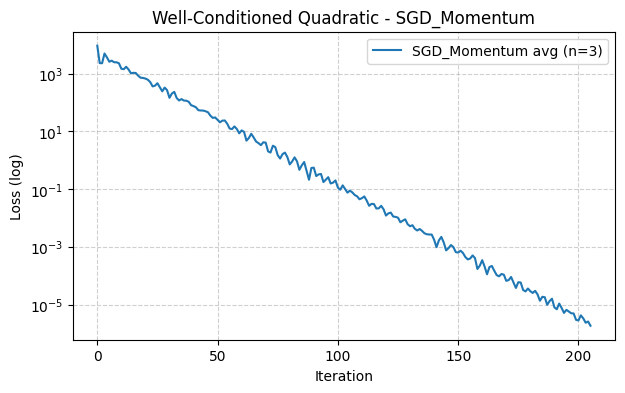

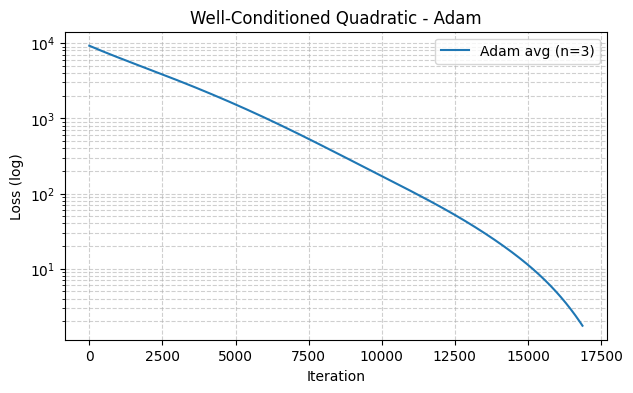

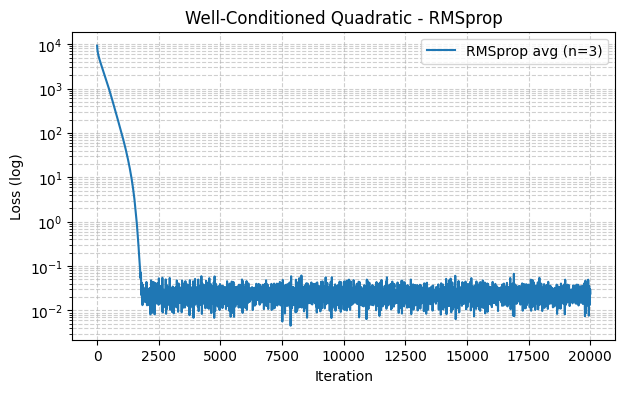

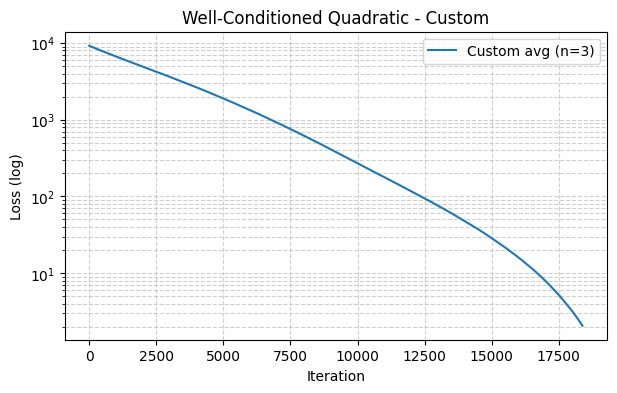

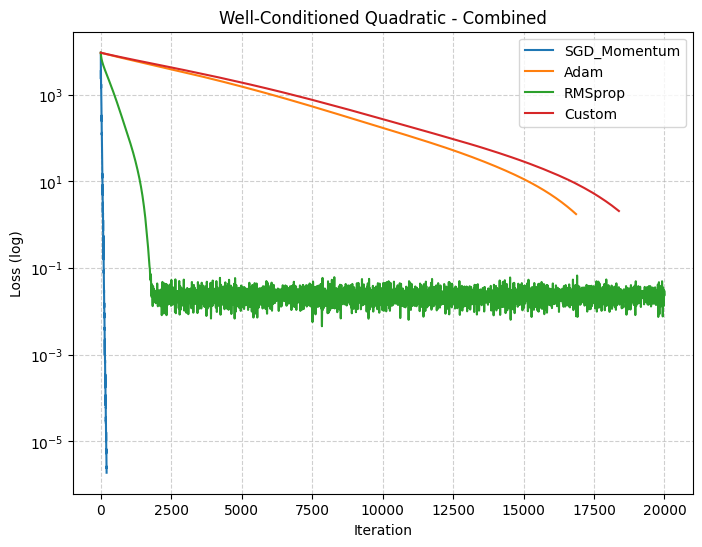


Summary (iterations to reach target, per run):
  SGD_Momentum : [210 205 215] (mean ± std = 210.0 ± 4.1)
  Adam         : [16863 19935 20000] (mean ± std = 18932.7 ± 1463.7)
  RMSprop      : [20000 20000 20000] (mean ± std = 20000.0 ± 0.0)
  Custom       : [18384 20000 20000] (mean ± std = 19461.3 ± 761.8)


In [ ]:

res = experiment_well_conditioned(n_dim=10, cond_num=10.0, target_loss=1e-6,
                                    max_iter=20000, n_runs=3)
print("\nSummary (iterations to reach target, per run):")
for name, data in res.items():
    arr = np.array(data['iters'])
    print(f"  {name:12s} : {arr} (mean ± std = {arr.mean():.1f} ± {arr.std():.1f})")


In [ ]:

res_rosen = experiment_rosenbrock(
    target_loss=1e-4,
    max_iter=20000,
    n_runs=3
)


for name, data in res_rosen.items():
    arr = np.array(data['iters'])
    print(f"  {name:12s} : {arr} (mean ± std = {arr.mean():.1f} ± {arr.std():.1f})")